The problem with the failed reconstruction seems to be in the Dense layers in encoder/decoder, immediately before/after the latent space. There are 2 ways to fix this:
1. Sigmoid activation in latent space + Reducing amount of neurons in Dense at beginning of Decoder.
2. Heavy weight regularization in latent space + lower weight initialization + Reducing amount of neurons in Dene ate beginning of Decoder.

In [2]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, nrows, ncols):
    ndata = np.zeros((len(data), nrows, ncols, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(ncols-width)
        y = np.random.randint(nrows-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
io_shape = (56,56,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16 * 4 # since we have 4x4-splits we need 4 times the latent space for a fair comparison.

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train = embed_and_translate(x_train, 56, 56)
x_train_split = np.array([utils.split(x, size, size) for x in x_train_augmented], dtype='float32')

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test = embed_and_translate(x_test, 56, 56)
x_test_split = np.array([utils.split(x, size, size) for x in x_test_augmented], dtype='float32')

1. Sigmoid activation + Reducing amount of Dense neurons in Decoder beginning.

In [3]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_pred = self.decode(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim, activation='sigmoid')  #! Sigmoid activation
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])

In [5]:
model = MultiSplit(n_splits, latent_dim, io_shape)
model.compile(loss='mse', optimizer='adam') # COMPILE AFTER WEIGHTS LOADED
# history = model.fit(x_train_split, x_train_augmented, validation_data=(x_test_split, x_test_augmented), epochs=5, batch_size=32)

In [7]:
# model.encoder.save_weights('../weights/30_CE4x16_epoch50.h5')
model.encoder.load_weights('../weights/34_CAE4x16_encoder_epoch100.h5')
model.decoder.load_weights('../weights/34_CAE4x16_decoder_head_epoch100.h5')

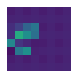

In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf


x = x_test_split[0].reshape(1,16,14,14,1)
z = model.encode(x, training=False)
y = model.decode(z, training=False)

a = np.empty((8,8))
for j in range(16):
    r = int(j/4)
    c = j%4
    a[r*2:(r+1)*2, c*2:(c+1)*2] = tf.reshape(z[j], (2,2))
axs.append(plt.subplot(3, n, n+i+1))
plt.axis('off')
plt.imshow(a, vmin=0, vmax=1)

plt.axis('off')
plt.savefig('../img/latent.png')
# n = 10
# plt.figure(figsize=(19, 6))
# axs = []
# for i in range(n):
    
#     # predict
#     x = x_test_split[i].reshape(1,16,14,14,1)
#     z = model.encode(x, training=False)
#     y = model.decode(z, training=False)
    
#     axs.append(plt.subplot(3, n, i+1))
#     plt.axis('off')
#     plt.imshow(x_test_augmented[i].reshape(56,56), vmin=0, vmax=1)
    
#     a = np.empty((8,8))
#     for j in range(16):
#         r = int(j/4)
#         c = j%4
#         a[r*2:(r+1)*2, c*2:(c+1)*2] = tf.reshape(z[j], (2,2))
#     axs.append(plt.subplot(3, n, n+i+1))
#     plt.axis('off')
#     plt.imshow(a, vmin=0, vmax=1)
    
#     axs.append(plt.subplot(3, n, 2*n+i+1))
#     plt.axis('off')
#     plt.imshow(tf.reshape(y, (56,56)), vmin=0, vmax=1)
# plt.colorbar(ax=axs)

2. Regularizing latent space layer by weight decay (L1: weights can become 0, L2: heavy panelization) + lower weight initialization + Reduce amount of neurons in first Dense layer of decoder.

In [46]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_pred = self.decode(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', kernel_initializer=keras.initializers.RandomNormal(stddev=0.001)),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', kernel_initializer=keras.initializers.RandomNormal(stddev=0.001)),
            Flatten(),
            Dense(units=latent_dim, kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.1), kernel_initializer=keras.initializers.RandomNormal(stddev=0.001))  #! Heavy weight regularization
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 4, kernel_initializer=keras.initializers.RandomNormal(stddev=0.001)),  #! Reduction of neurons by factor 8.
            Reshape((io_shape[0]//4, io_shape[1]//4, 4)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', kernel_initializer=keras.initializers.RandomNormal(stddev=0.001)),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', kernel_initializer=keras.initializers.RandomNormal(stddev=0.001)),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same', kernel_initializer=keras.initializers.RandomNormal(stddev=0.001)),
            Activation('sigmoid', name='decoder_out')
        ])

In [47]:
model = MultiSplit(n_splits, latent_dim, io_shape)
model.compile(loss='mse', optimizer='adam') # COMPILE AFTER WEIGHTS LOADED
history = model.fit(x_train_split, x_train_augmented, validation_data=(x_test_split, x_test_augmented), epochs=5, batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0176 - val_loss: 0.0088
Epoch 2/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 3/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 4/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 5/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0070 - val_loss: 0.0069


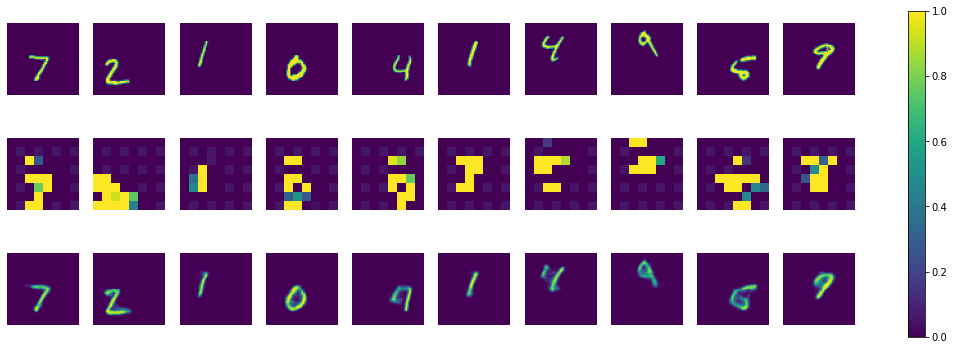

In [48]:
import matplotlib.pyplot as plt
import tensorflow as tf

n = 10
plt.figure(figsize=(19, 6))
axs = []
for i in range(n):
    
    # predict
    x = x_test_split[i].reshape(1,16,14,14,1)
    z = model.encode(x, training=False)
    y = model.decode(z, training=False)
    
    axs.append(plt.subplot(3, n, i+1))
    plt.axis('off')
    plt.imshow(x_test_augmented[i].reshape(56,56), vmin=0, vmax=1)
    
    a = np.empty((8,8))
    for j in range(16):
        r = int(j/4)
        c = j%4
        a[r*2:(r+1)*2, c*2:(c+1)*2] = tf.reshape(z[j], (2,2))
    axs.append(plt.subplot(3, n, n+i+1))
    plt.axis('off')
    plt.imshow(a, vmin=0, vmax=1)
    
    axs.append(plt.subplot(3, n, 2*n+i+1))
    plt.axis('off')
    plt.imshow(tf.reshape(y, (56,56)), vmin=0, vmax=1)
plt.colorbar(ax=axs)